## Clustering

### Demonstrate Clustering concepts with Stock % Change Data

A stock trading strategy is <i>pairs trading</i> involves monitoring two historically correlated securities. Once a discrepancy such as one stock going up and the other remaining stagnant is identified, an investor can go long on the underperforming security and short on the outperforming security, hoping that the securities return to their historical correlation. In the case that this does happen, the investor makes a profit from the convergence of the prices.

## <font color=blue>Import needed modules</font>

In [1]:
# general libraries always needed
import pandas as pd
import numpy as np
import math

# sourcing data
import os
import os.path
import urllib

# plotting required modules
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FixedLocator, FixedFormatter

# sklearn clustering / unsupervised learning modules
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# sklearn modules for preprocessing and transformation
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [2]:
# function to create an Avg. Distance to Nearest Neighbor plt
def nn_avg_distance(X):
    plt.figure(figsize=(10,5))
    nn = NearestNeighbors(n_neighbors=15).fit(X)
    distances, idx = nn.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)
    plt.xlabel("Instances", fontsize=14)
    plt.ylabel("Distances", fontsize=14)
    plt.title("Average Distance to Nearset Neighbor")
    plt.show()

In [3]:
# function to create a silhouette diagram
# requires the model, the independent value (i.e. X) used to fit the model, and a list of k values to plot

def inertia_silhouette_plot( X, k_values): 

    # iterate through different k values and collect inertia values and silhouette scores
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, max(k_values)+1)]
    inertias = [model.inertia_ for model in kmeans_per_k]
    silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]    
    
    # print the silhouette scores and k values
    plt.plot(inertias)
    plt.ylabel("Inertia", fontsize=14)
    plt.xlabel("k Value", fontsize=14)
    plt.show()
    print("-"*80)
    # create the plot's figure
    plt.figure(figsize=(10, len(k_values)*3))

    ct = 0 # temp counter variable

    # build a subplot for each value of k
    for k in k_values:
    
        # create the subplot
        ct +=1
        plt.subplot(math.ceil(len(k_values)/2), 2, ct)
    
        # get the predictions and silhouette value
        y_pred = kmeans_per_k[k - 1].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)

        # create the bars for each cluster
        padding = len(X) // 30
        pos = padding
        ticks = []
        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

       # plot the silhouette line
        plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
        
        # chart title
        plt.title("k={} --- {:.2}".format(k, silhouette_scores[k - 2]), fontsize=16)
 
        # add a y label for each row and an x axis label for the last 2 graphs
        if ct%2 == 1:
            plt.ylabel("Cluster")
        if ct == len(k_values) or ct==len(k_values)-1:
            #plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
            plt.xlabel("Silhouette Coefficient")
                
    # plot
    plt.show()

In [4]:
# function to create a 2 dimmensional representation of data usint tSNE
# needs the independent data as well as the DBSCAN prediction
def dbscan_tsne_plot(X, prediction):
    X_tsne = TSNE(learning_rate=1000, perplexity=25).fit_transform(X)
    plt.figure(1, facecolor='white')
    plt.scatter(
        X_tsne[(prediction!=-1), 0],
        X_tsne[(prediction!=-1), 1],
        s=100,
        alpha=0.85,
        c=prediction[prediction!=-1],
        cmap=cm.Paired
    )
    plt.scatter(
        X_tsne[(prediction==-1), 0],
        X_tsne[(prediction==-1), 1],
        s=100,
        alpha=0.05
    )
    plt.title('T-SNE with DBSCAN Clusters Noted')
    plt.show()

## <font color=blue>Source data</font>

In [5]:
# download data files if not currently downloaded into the current working directory
DOWNLOAD_DIR = "/Users/Nik/Documents/OneDrive - Villanova University/Machine Learning & AI with Python - Spring 2021/Modules/Module 4/"
filenames = ["AllTickers.csv",'sp500.csv']

for filename in filenames:
    if not os.path.isfile(DOWNLOAD_DIR + filename):
        DOWNLOAD_ROOT = "https://raw.githubusercontent.com/SueMcMetzger/MachineLearning/main/chpt8/"
        url = DOWNLOAD_ROOT + filename
        urllib.request.urlretrieve(url, DOWNLOAD_DIR+filename)
        print("Downloaded", filename)  

In [6]:
# read files into dataframes
pricechange = pd.read_csv(DOWNLOAD_DIR+filenames[0])
sp500 = pd.read_csv(DOWNLOAD_DIR+filenames[1])

## <font color=blue>Analyze and Prepare Data</font>

In [7]:
# this data set includes the % price change of stocks week over week
pricechange.head()

,Ticker,29-Dec-20,24-Dec-20,18-Dec-20,11-Dec-20,4-Dec-20,27-Nov-20,20-Nov-20,13-Nov-20,6-Nov-20,...,6-Mar-15,27-Feb-15,20-Feb-15,13-Feb-15,6-Feb-15,30-Jan-15,23-Jan-15,16-Jan-15,9-Jan-15,2-Jan-15
0,A,-0.000682,-0.016681,0.006921,0.028919,0.009291,0.028857,0.006535,-0.021059,0.102361,...,-0.016110,0.006198,0.044832,0.020590,0.041567,-0.026797,0.014641,-0.057650,0.000740,-0.019816
1,AAL,0.012771,-0.051484,-0.031672,0.039634,0.094793,0.195531,0.023693,0.068063,0.015957,...,0.001983,-0.061152,0.054350,0.005089,-0.019051,-0.118693,0.118049,-0.042484,-0.035058,0.037629
2,AAP,-0.024832,0.004313,0.014779,0.034039,0.016941,0.038800,-0.062792,-0.015219,0.061787,...,-0.037824,-0.000838,0.032632,-0.073086,0.018868,0.020670,0.038533,-0.064255,0.010974,-0.009000
3,AAPL,0.021975,0.041964,0.034679,0.001309,0.048546,-0.006392,-0.016099,0.004802,0.090299,...,-0.014479,-0.007993,0.019004,0.068528,0.015108,0.036998,0.065950,-0.053745,0.024513,-0.040881
4,ABBV,0.013945,-0.011393,-0.017773,-0.008762,0.022786,0.040163,0.018174,0.066667,0.091069,...,-0.080331,-0.013051,0.055986,0.020211,-0.057167,-0.033317,-0.032693,-0.018851,-0.001669,-0.016274


In [8]:
# drop any S&P 500 Stocks that did not have complete data
pricechange.dropna(axis=0, inplace=True)  

In [9]:
# this data set list all S&P 500 stocks and their details
sp500.head()

,Symbol,Security,SandP100,FoundedYear,YearOnList,Sector,StateCountry
0,A,Agilent Technologies Inc,0,1999,2000.0,Health Care,California
1,AAL,American Airlines Group,0,1934,2015.0,Industrials,Texas
2,AAP,Advance Auto Parts,0,1932,2015.0,Consumer Discretionary,North Carolina
3,AAPL,Apple Inc.,1,1977,1982.0,Information Technology,California
4,ABBV,AbbVie Inc.,1,2013,2012.0,Health Care,Illinois


In [10]:
# inner join the 2 data sets using thier Ticker/Symbol columns
data = sp500.merge(pricechange,left_on='Symbol',right_on='Ticker',how='inner')
data.drop(['Ticker'],inplace=True,axis=1) #Remove the duplicate Ticker/Symbol column

In [11]:
data.head()

,Symbol,Security,SandP100,FoundedYear,YearOnList,Sector,StateCountry,29-Dec-20,24-Dec-20,18-Dec-20,...,6-Mar-15,27-Feb-15,20-Feb-15,13-Feb-15,6-Feb-15,30-Jan-15,23-Jan-15,16-Jan-15,9-Jan-15,2-Jan-15
0,A,Agilent Technologies Inc,0,1999,2000.0,Health Care,California,-0.000682,-0.016681,0.006921,...,-0.016110,0.006198,0.044832,0.020590,0.041567,-0.026797,0.014641,-0.057650,0.000740,-0.019816
1,AAL,American Airlines Group,0,1934,2015.0,Industrials,Texas,0.012771,-0.051484,-0.031672,...,0.001983,-0.061152,0.054350,0.005089,-0.019051,-0.118693,0.118049,-0.042484,-0.035058,0.037629
2,AAP,Advance Auto Parts,0,1932,2015.0,Consumer Discretionary,North Carolina,-0.024832,0.004313,0.014779,...,-0.037824,-0.000838,0.032632,-0.073086,0.018868,0.020670,0.038533,-0.064255,0.010974,-0.009000
3,AAPL,Apple Inc.,1,1977,1982.0,Information Technology,California,0.021975,0.041964,0.034679,...,-0.014479,-0.007993,0.019004,0.068528,0.015108,0.036998,0.065950,-0.053745,0.024513,-0.040881
4,ABBV,AbbVie Inc.,1,2013,2012.0,Health Care,Illinois,0.013945,-0.011393,-0.017773,...,-0.080331,-0.013051,0.055986,0.020211,-0.057167,-0.033317,-0.032693,-0.018851,-0.001669,-0.016274


### No need to split data for unsupervised learning (but must prepare it)

### Build Transformation Pipeline

In [12]:
# no categorical attributes for this data set (nice to have in case data changes)
cat_attribs = ['StateCountry','Sector']

# set the numerical attributes
num_attribs = list( data.drop(['StateCountry','Sector','Symbol','Security'], axis=1) )

# define pipeline for numeric attributes (this code is just a definition)
# each numeric attribute will be imputated using the Median strategy
# each numeric attribute will be scaled 
num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
 ('std_scaler', StandardScaler()),   
])

# define the pipeline process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)      
])

### Create X data set

In [13]:
X = full_pipeline.fit_transform( data.drop(['Symbol','Security'], axis=1) )
X.shape

(476, 347)

## <font color=blue>K-Means

Let's train a K-Means cluster on this data set. It will try to find each blob's center and assign each instance to the closest blob.

## <font color=red>How many clusters?

### Plot Inertia & Silhouette Coefficient

To determine an ideal <i>k</i> value, need to look where there is low inertia (mean square error between each instance & centroid) and a high (close to 1) silhouette coefficient (proximity to cluster boundries)

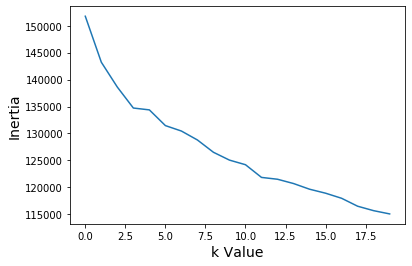

--------------------------------------------------------------------------------


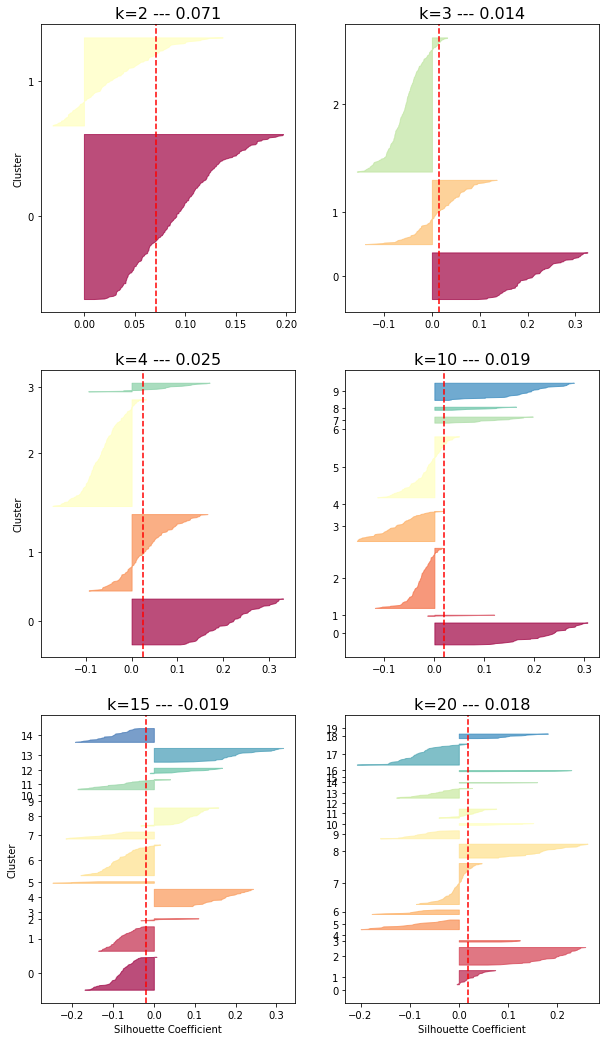

In [14]:
# use this function to evaluate your X data across different k values
# NOTE: this function can take a little time especially if your k value list has numbers > 20
inertia_silhouette_plot(X, [2, 3, 4, 10, 15, 20])

In [15]:
k = 15

# create the model
kmeans = KMeans(n_clusters=k, random_state=42)

# fit the model and predict y values (i.e. cluster value)
y_pred = kmeans.fit_predict(X)

Each instance was assigned to one of the k clusters

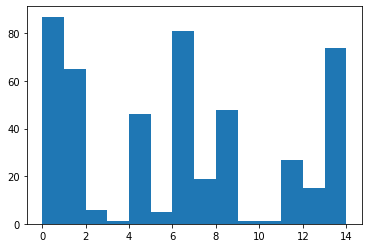

In [16]:
# plot the number of instances in each of the created clusters
plt.hist(y_pred, bins=range(k))
plt.show()

In [17]:
# explore some of the clusters
data[ y_pred == 5]

,Symbol,Security,SandP100,FoundedYear,YearOnList,Sector,StateCountry,29-Dec-20,24-Dec-20,18-Dec-20,...,6-Mar-15,27-Feb-15,20-Feb-15,13-Feb-15,6-Feb-15,30-Jan-15,23-Jan-15,16-Jan-15,9-Jan-15,2-Jan-15
139,DXCM,DexCom,0,1999,2020.0,Health Care,California,0.021830,-0.009900,0.031233,...,-0.018933,-0.057125,0.027760,0.003201,0.045166,0.031757,-0.017467,0.013404,0.067511,-0.011605
306,NFLX,Netflix Inc.,1,1997,2010.0,Communication Services,California,0.020663,-0.038320,0.062060,...,-0.043777,-0.006880,0.025960,0.048924,0.005794,0.009932,0.296778,0.024447,-0.056313,0.026143
319,NVDA,Nvidia Corporation,1,1993,2001.0,Information Technology,California,0.011698,-0.020965,0.019884,...,0.022212,-0.012313,0.001121,0.093627,0.062223,-0.072670,0.037575,0.001003,-0.009439,-0.022341
418,TSLA,"Tesla, Inc.",1,2003,2020.0,Consumer Discretionary,California,0.049881,-0.047813,0.139363,...,-0.046523,-0.063424,0.065466,-0.062523,0.067583,0.011476,0.042575,-0.065760,-0.057681,-0.037354
422,TWTR,"Twitter, Inc.",0,2006,2018.0,Communication Services,California,0.006670,-0.034008,0.086120,...,-0.027662,-0.020973,0.012577,0.010206,0.279243,-0.047945,0.056553,-0.071197,0.098742,-0.027660


## <font color=blue>DBSCAN 

#### Defines clusters using continuous regions of high density but not able to predict 

In [18]:
# create and fit the model
dbscan = DBSCAN(eps=11.5, min_samples=5)      #epsilon defines the neighborhood distance
dbscan.fit(X)

DBSCAN(eps=11.5)

In [19]:
y_pred=dbscan.labels_
set(list(y_pred))

{-1, 0, 1, 2, 3, 4}

In [20]:
data[ y_pred== 1 ]

,Symbol,Security,SandP100,FoundedYear,YearOnList,Sector,StateCountry,29-Dec-20,24-Dec-20,18-Dec-20,...,6-Mar-15,27-Feb-15,20-Feb-15,13-Feb-15,6-Feb-15,30-Jan-15,23-Jan-15,16-Jan-15,9-Jan-15,2-Jan-15
30,AME,AMETEK Inc.,0,1930,2013.0,Industrials,Pennsylvania,-0.003192,0.007959,-0.002365,...,-0.021076,0.029446,0.004085,0.036283,0.035699,-0.019046,0.005560,-0.047656,-0.030977,-0.025195
207,HON,Honeywell Int'l Inc.,1,1906,1964.0,Industrials,New Jersey,0.006777,-0.002428,-0.021386,...,-0.008854,-0.024487,0.009389,0.025848,0.040814,-0.046244,0.043576,-0.007177,-0.012970,-0.013775
217,IEX,IDEX Corporation,0,1988,2019.0,Industrials,Illinois,0.000356,-0.010023,0.029130,...,-0.024592,-0.014918,0.016723,0.030595,0.034554,-0.010666,0.013442,-0.038892,-0.035953,-0.006759
231,ITW,Illinois Tool Works,0,1912,1986.0,Industrials,Illinois,-0.001334,-0.007063,0.001572,...,-0.011026,-0.006332,0.012518,0.012051,0.042969,-0.005024,0.002894,-0.002992,-0.011724,-0.024219
287,MMM,3M Company,1,1902,1976.0,Industrials,Minnesota,-0.002349,-0.010770,0.013792,...,-0.025437,0.003153,0.013137,-0.000783,0.023229,-0.010487,0.012469,0.002351,-0.014873,-0.013232
342,PH,Parker-Hannifin,0,1917,1985.0,Industrials,Ohio,0.002858,-0.009375,-0.009757,...,-0.036026,-0.008085,-0.002982,0.028861,0.035377,-0.045175,0.016417,-0.046484,-0.025627,-0.012463
373,ROP,Roper Technologies,0,1981,2009.0,Industrials,Florida,0.004046,-0.014242,0.013652,...,-0.009310,-0.004337,0.012453,0.031715,0.043929,0.030995,0.027101,-0.037128,-0.033521,-0.019961


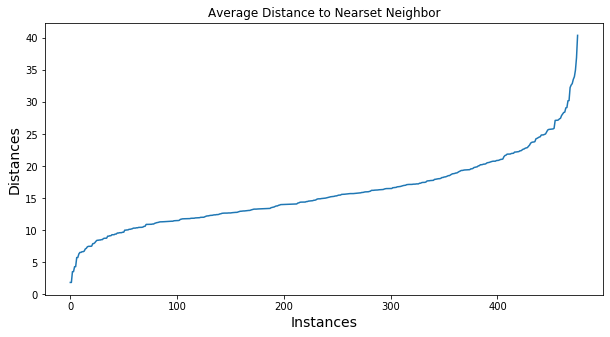

In [21]:
# But how was an epsilon of 10 determined?
# one method is to review the Avg. Distances to Nearest Neighbor graph and find its "elbow point"
nn_avg_distance(X)

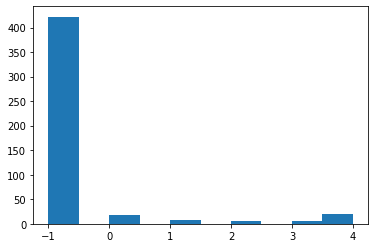

In [22]:
# plot the number of instances in each of the created clusters
plt.hist(y_pred, bins=10)
plt.show()

In [23]:
data[ y_pred == 4 ]

,Symbol,Security,SandP100,FoundedYear,YearOnList,Sector,StateCountry,29-Dec-20,24-Dec-20,18-Dec-20,...,6-Mar-15,27-Feb-15,20-Feb-15,13-Feb-15,6-Feb-15,30-Jan-15,23-Jan-15,16-Jan-15,9-Jan-15,2-Jan-15
54,BAC,Bank of America Corp,1,1998,1976.0,Financials,North Carolina,0.001669,0.044995,0.003500,...,0.025933,-0.034799,-0.013847,0.007277,0.088449,-0.036872,0.022757,-0.094229,-0.051397,-0.004449
70,C,Citigroup Inc.,1,1998,1988.0,Financials,New York,0.004788,0.025567,0.002206,...,0.012209,0.012360,0.011328,0.041921,0.046645,-0.034348,0.021214,-0.062426,-0.064136,-0.003123
83,CFG,Citizens Financial Group,0,1828,2016.0,Financials,Other,0.007973,0.026600,-0.032796,...,0.026570,-0.016238,-0.007859,0.038776,0.025105,0.008013,0.022423,-0.029301,-0.035137,-0.021731
91,CMA,Comerica Inc.,0,1849,1995.0,Financials,Texas,-0.002862,0.062132,-0.001139,...,0.028834,-0.001091,-0.012710,0.006068,0.111807,-0.008837,0.009646,-0.027667,-0.078635,-0.011109
171,FITB,Fifth Third Bancorp,0,1858,NaN,Financials,Ohio,-0.010877,0.035674,-0.025969,...,0.004649,-0.001547,0.006750,0.019587,0.091908,-0.020939,-0.034426,-0.033281,-0.063335,-0.018456
184,GL,Globe Life Inc.,0,1900,1989.0,Financials,Texas,0.003661,0.000646,-0.009498,...,0.010141,-0.017165,0.002405,0.019619,0.058718,-0.032651,-0.001736,-0.013696,-0.029357,-0.019906
193,GS,Goldman Sachs Group,1,1869,2002.0,Financials,New York,0.012844,0.057944,0.008917,...,-0.015175,-0.008981,0.013280,0.030366,0.063917,-0.044767,0.018394,-0.054017,-0.036315,-0.005321
197,HBAN,Huntington Bancshares,0,1866,NaN,Financials,Ohio,0.017004,-0.003228,-0.041763,...,0.006399,0.020522,0.002806,0.026897,0.038922,-0.001992,0.012097,-0.007007,-0.048571,-0.006623
239,JPM,JPMorgan Chase & Co.,1,2000,1975.0,Financials,New York,0.006746,0.045684,-0.004015,...,-0.006364,0.024749,0.002179,0.030748,0.064546,-0.040579,0.013410,-0.057465,-0.050408,-0.000959
241,KEY,KeyCorp,0,1825,1994.0,Financials,Ohio,0.003706,0.049935,-0.026515,...,0.027279,-0.006419,-0.006378,-0.003531,0.090069,-0.021100,0.070161,-0.047619,-0.060606,-0.010000


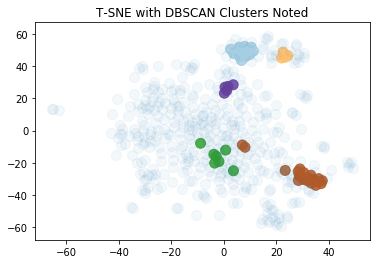

In [24]:
# plot DBSCAN results on a 2-dimensional tSNE of the same data set
dbscan_tsne_plot(X, y_pred)

# <font color=red>How many clusters?

## <font color=blue>Bayesian Guassian Mixture

#### Supports finding the k value for Gaussian Mixture models

In [25]:
# create a model and fit X

# set the k value to your best guess (or higher)
# n_init defines how many times to fit the model
bgm = BayesianGaussianMixture(n_components=10, n_init=10)  
bgm.fit(X)

BayesianGaussianMixture(n_components=10, n_init=10)

In [26]:
# let's look at the weights to possible clusters and zero to all unneeded clusters
weights = np.round(bgm.weights_,2)
weights

array([0.24, 0.01, 0.09, 0.02, 0.25, 0.03, 0.11, 0.11, 0.  , 0.13])

In [27]:
# calculate the ideal k value (or just count the values above)
k = len(set(list(weights)))-1
k

8

## <font color=blue>Gaussian Mixture

Using a probalistic model that clusters based on instances having similar Gaussian (i.e. normal) distribution

In [28]:
# Let's train a Gaussian Mixture on this dataset. 
k = 8
gauss = GaussianMixture(n_components=k, random_state=42)
y_pred = gauss.fit_predict(X)

In [29]:
# the most likely cluster (hard clustering) predictions made
y_pred

array([4, 2, 4, 0, 5, 4, 0, 4, 4, 0, 0, 6, 4, 0, 3, 3, 3, 4, 2, 4, 4, 0,
       6, 0, 2, 4, 4, 5, 0, 0, 6, 5, 2, 3, 0, 0, 0, 4, 4, 6, 1, 6, 6, 6,
       3, 3, 0, 3, 0, 6, 3, 2, 4, 6, 2, 4, 4, 4, 2, 5, 4, 2, 0, 6, 4, 5,
       4, 4, 6, 3, 2, 7, 4, 6, 4, 4, 3, 2, 0, 4, 6, 4, 2, 2, 7, 6, 4, 4,
       4, 7, 7, 2, 4, 4, 4, 6, 3, 4, 3, 2, 6, 4, 2, 4, 7, 4, 0, 4, 6, 4,
       0, 4, 4, 4, 6, 2, 3, 2, 6, 6, 2, 4, 4, 4, 4, 4, 2, 2, 2, 3, 4, 6,
       4, 3, 4, 3, 3, 4, 2, 0, 0, 0, 4, 3, 4, 3, 4, 6, 6, 2, 3, 3, 3, 3,
       6, 3, 4, 6, 4, 3, 6, 2, 6, 0, 6, 2, 6, 3, 6, 4, 4, 2, 6, 2, 4, 6,
       2, 3, 2, 0, 6, 2, 5, 7, 6, 6, 6, 0, 0, 6, 4, 2, 6, 2, 6, 2, 4, 2,
       6, 4, 4, 2, 2, 6, 6, 6, 4, 6, 6, 7, 4, 7, 4, 2, 6, 4, 0, 6, 4, 5,
       5, 4, 6, 0, 6, 4, 0, 4, 3, 4, 4, 6, 2, 6, 6, 6, 4, 7, 6, 2, 7, 2,
       0, 3, 0, 7, 6, 4, 7, 7, 6, 6, 2, 4, 6, 4, 4, 4, 6, 5, 4, 2, 3, 4,
       0, 6, 2, 6, 2, 4, 0, 3, 6, 6, 4, 0, 4, 4, 7, 4, 2, 6, 6, 7, 4, 6,
       4, 6, 4, 7, 2, 2, 4, 2, 2, 4, 0, 4, 2, 4, 0,

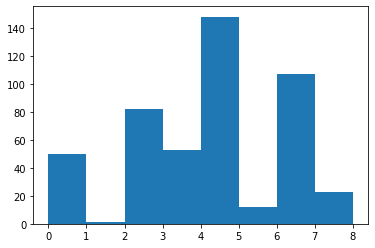

In [30]:
# plot the number of instances in each of the created clusters
plt.hist(y_pred, bins=range(k+1))
plt.show()

In [31]:
data[ y_pred == 5 ]

,Symbol,Security,SandP100,FoundedYear,YearOnList,Sector,StateCountry,29-Dec-20,24-Dec-20,18-Dec-20,...,6-Mar-15,27-Feb-15,20-Feb-15,13-Feb-15,6-Feb-15,30-Jan-15,23-Jan-15,16-Jan-15,9-Jan-15,2-Jan-15
4,ABBV,AbbVie Inc.,1,2013,2012.0,Health Care,Illinois,0.013945,-0.011393,-0.017773,...,-0.080331,-0.013051,0.055986,0.020211,-0.057167,-0.033317,-0.032693,-0.018851,-0.001669,-0.016274
27,ALXN,Alexion Pharmaceuticals,0,1992,2012.0,Health Care,Massachusetts,0.017821,-0.026284,0.295669,...,0.007097,-0.030373,0.020462,0.037921,-0.041530,-0.000436,0.015961,-0.020785,-0.012487,-0.004720
31,AMGN,Amgen Inc.,1,1980,1992.0,Health Care,California,0.017674,-0.024334,0.004793,...,-0.018007,0.000381,0.027235,0.013738,-0.005648,-0.047244,0.008710,0.017338,-0.026018,-0.021840
59,BIIB,Biogen Inc.,1,1978,2003.0,Health Care,Massachusetts,-0.021335,-0.002924,0.033923,...,0.019629,0.003774,0.041848,-0.025721,0.032994,0.088468,0.013551,0.030408,0.000965,-0.001139
65,BMY,Bristol-Myers Squibb,1,1989,1957.0,Health Care,New York,0.012592,-0.031210,0.039526,...,0.068943,0.006609,0.007995,0.006201,-0.009955,-0.029000,-0.003852,0.032991,0.013611,-0.001175
182,GILD,Gilead Sciences,1,1987,2004.0,Health Care,California,-0.007359,-0.034022,-0.027650,...,-0.016614,0.008966,0.006968,0.045343,-0.070114,-0.006727,0.047959,-0.014676,0.076915,0.011942
219,ILMN,Illumina Inc,0,1998,2015.0,Health Care,California,-0.008712,0.003360,0.070320,...,-0.011869,-0.037783,0.023144,0.030627,-0.013064,-0.009992,0.072571,-0.056366,0.050588,-0.014772
220,INCY,Incyte,0,1991,2017.0,Health Care,Other,-0.005837,-0.010980,0.086593,...,0.048340,0.040732,0.086252,0.007830,-0.054698,-0.002378,0.074213,0.032625,-0.023454,-0.001759
259,LLY,Lilly (Eli) & Co.,1,1876,1970.0,Health Care,Other,0.002100,-0.027655,0.070982,...,-0.025082,-0.023790,0.018707,0.002843,-0.022778,-0.001802,0.020515,0.010725,-0.001856,-0.004688
354,PRGO,Perrigo,0,2013,2011.0,Health Care,International,0.010679,-0.045129,-0.035976,...,0.015278,0.020480,0.003115,0.003792,-0.009292,-0.033503,-0.021929,-0.054374,0.018724,0.004037
